In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

from patsy import dmatrix
from utils import preprocess_data_for_apc_analysis
from simulation import simulate_lending
from utils import prepare_period_cohort_table, preprocess_data_for_apc_analysis

import fredapi as fd
fred = fd.Fred(api_key='f9359e11d5921a988a3a340406c3fc55')

import matplotlib.pyplot as plt
palette = ['#001A72', '#FC4C02', '#41B6E6', '#B7C01B', '#00D4C5', '#00A499', '#DBE442']
bg = '#EBF6F3'

plt.rcParams.update({'axes.facecolor':bg})
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=palette)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
uk_cpi = fred.get_series("GBRCPIALLMINMEI")
uk_unemp = fred.get_series("LRUN64TTGBQ156S")
test_cutoff_year = 2020

In [3]:
real_beta_0 = 0
real_beta_age = pd.Series([0, .2, .1, 0, -.2, -.3, -.4, -.5, -.6, -.7, -.8, -.9, -1, -1.25, -1.5])
real_beta_unemp_period, real_beta_inflation_period = 6, 8
real_beta_unemp_cohort, real_beta_inflation_cohort = 0, 0
period_cohort_table = prepare_period_cohort_table(
    uk_cpi, uk_unemp,
    real_beta_unemp_period, real_beta_inflation_period,
    real_beta_unemp_cohort, real_beta_inflation_cohort
)
period_cohort_table["cohort"] = np.random.normal(0, 0.05, size = len(period_cohort_table)).cumsum() - 3
yob = simulate_lending(period_cohort_table, real_beta_0, real_beta_age)

  0% (0 of 33) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  3% (1 of 33) |                         | Elapsed Time: 0:00:00 ETA:   0:00:07
  6% (2 of 33) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:07
  9% (3 of 33) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:09
 12% (4 of 33) |###                      | Elapsed Time: 0:00:01 ETA:   0:00:10
 15% (5 of 33) |###                      | Elapsed Time: 0:00:02 ETA:   0:00:11
 18% (6 of 33) |####                     | Elapsed Time: 0:00:02 ETA:   0:00:12
 21% (7 of 33) |#####                    | Elapsed Time: 0:00:03 ETA:   0:00:13
 24% (8 of 33) |######                   | Elapsed Time: 0:00:04 ETA:   0:00:14
 27% (9 of 33) |######                   | Elapsed Time: 0:00:05 ETA:   0:00:14
 30% (10 of 33) |#######                 | Elapsed Time: 0:00:06 ETA:   0:00:15
 33% (11 of 33) |########                | Elapsed Time: 0:00:07 ETA:   0:00:15
 36% (12 of 33) |########               

In [4]:
data = yob.groupby("period")[["default"]].sum().reset_index().merge(
    yob.groupby("period")[["loan_id"]].count().reset_index().rename(columns = {"loan_id":"loans"})
).set_index("period")

In [5]:
num_knots = 6
knot_list = np.linspace(
    data.index.min(),
    data.index.max(),
    num_knots + 2
)[1:-1]

In [6]:
B = dmatrix(
    "bs(default, knots=knots, degree=3, include_intercept=True) - 1",
    {"default": data.index.values, "knots":knot_list[1:-1]}
)

In [7]:
with pm.Model() as simple_splines_model:
    tau = pm.HalfCauchy("tau", 1)
    beta = pm.Normal("beta", mu = 0, sigma=tau, shape=B.shape[1])
    p =  pm.Deterministic(
        "p", 
        pm.math.invlogit(
            pm.math.dot(B, beta)
        )
    )
    N = pm.Data("N", data["loans"].values)
    d = pm.Binomial("default", N, p, observed=data["default"].values)
    simple_splines_idata = pm.sample(1000, chains = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tau, beta]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [8]:
with simple_splines_model:
    ppc = pm.sample_posterior_predictive(simple_splines_idata, var_names = ["default", "p"])

Sampling: [default]


Output()

<Axes: xlabel='period'>

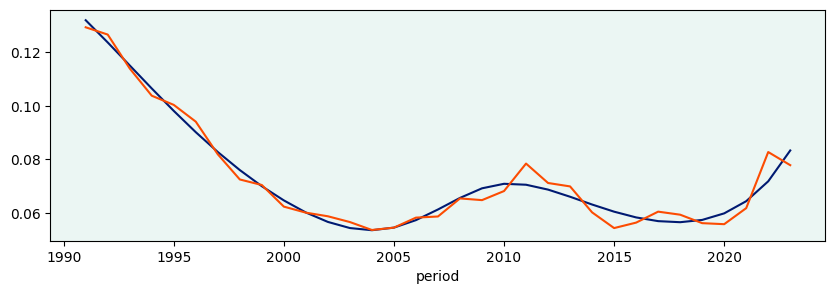

In [9]:
_, ax = plt.subplots(figsize = (10, 3))
ax.plot(
    data.index.values,
    ppc["posterior_predictive"]["p"].mean(axis = 1)[0, :]
)
(data["default"]/data["loans"]).plot()

In [10]:
apc_df, apc_df_test = preprocess_data_for_apc_analysis(yob, period_cohort_table, test_cutoff_year)
apc_df.head()

size   sum     unemp  inflation
age period cohort                                  
0   1991   1991    10000  1293  0.088915   0.069437
    1992   1992    10000  1154  0.100419   0.043900
1   1992   1991     8707  1214  0.100419   0.043900
0   1993   1993    10000  1017  0.104778   0.024947
1   1993   1992     8846  1128  0.104778   0.024947

In [11]:
knot_list_cohort = np.linspace(
    apc_df.index.get_level_values("cohort").min(),
    apc_df.index.get_level_values("cohort").max(),
    num_knots + 2
)[1:-1]

B_cohort = dmatrix(
    "bs(default, knots=knots, degree=3, include_intercept=True) - 1",
    {"default": apc_df.index.get_level_values("cohort"), "knots":knot_list_cohort[1:-1]}
)

In [12]:
knot_list_age = np.linspace(
    apc_df.index.get_level_values("age").min(),
    apc_df.index.get_level_values("age").max(),
    num_knots + 2
)[1:-1]

B_age = dmatrix(
    "bs(default, knots=knots, degree=3, include_intercept=False) - 1",
    {"default": apc_df.index.get_level_values("age"), "knots":knot_list_age[1:-1]}
)

In [13]:
with pm.Model() as apc_model:
    # beta_0 = pm.Normal("beta_0", 0, 10)
    
    beta_inflation = pm.Normal("beta_inflation", 0, 10)
    beta_unemp = pm.Normal("beta_unemp", 0, 10)
    
    tau_cohort = pm.HalfCauchy("tau_cohort", 1)
    beta_cohort = pm.Normal("beta_cohort", mu = 0, sigma=tau_cohort, shape=B_cohort.shape[1])

    tau_age = pm.HalfCauchy("tau_age", 1)
    beta_age = pm.Normal("beta_age", mu = 0, sigma=tau_age, shape=B_age.shape[1])

    inflation = pm.Data("inflation", apc_df["inflation"].values)
    unemp = pm.Data("unemp", apc_df["unemp"].values)
    N = pm.Data("N", apc_df["size"].values)

    p = pm.Deterministic(
        "p", 
        pm.math.invlogit(
            # beta_0 + 
            beta_inflation*inflation + 
            beta_unemp*unemp + 
            pm.math.dot(B_age, beta_age) + 
            pm.math.dot(B_cohort, beta_cohort)
        )
    )

    pm.Binomial("default", N, p, observed=apc_df["sum"].values)
    apc_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_inflation, beta_unemp, tau_cohort, beta_cohort, tau_age, beta_age]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


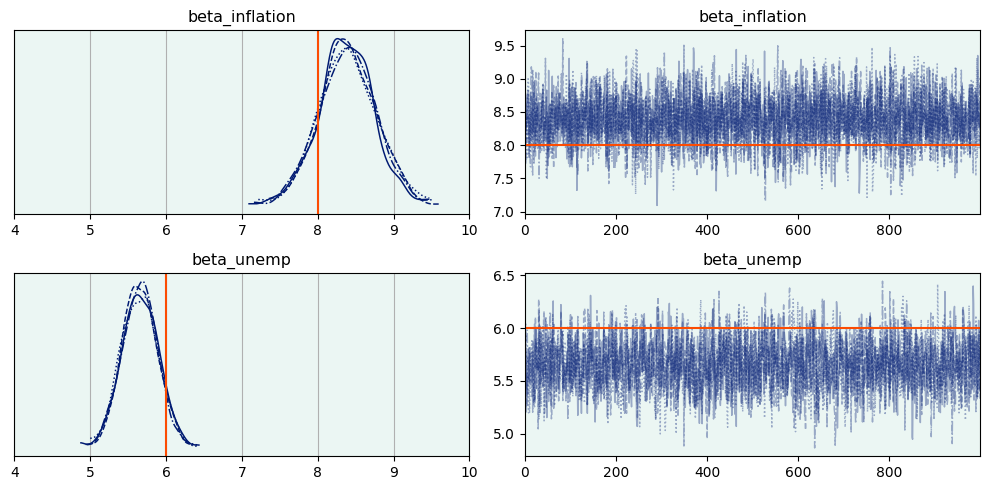

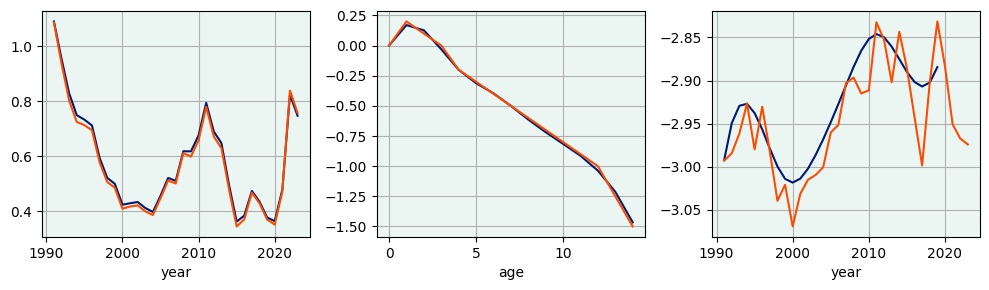

In [14]:
axs = az.plot_trace(apc_trace, var_names = ["beta_inflation", "beta_unemp"], figsize = (10, 5))
axs[0, 0].axvline(real_beta_inflation_period, color = palette[1])
axs[0, 1].axhline(real_beta_inflation_period, color = palette[1])
axs[0, 0].grid()
axs[0, 0].set_xlim(4, 10)

axs[1, 0].axvline(real_beta_unemp_period, color = palette[1])
axs[1, 1].axhline(real_beta_unemp_period, color = palette[1])
axs[1, 0].grid()
axs[1, 0].set_xlim(4, 10)
plt.tight_layout()



_, axs = plt.subplots(1, 3, figsize = (10, 3))
ax = axs[0]
period_pred = pd.Series(
    float(apc_trace["posterior"]["beta_inflation"].mean())*period_cohort_table["inflation"].values + 
    float(apc_trace["posterior"]["beta_unemp"].mean())*period_cohort_table["unemp"].values
)
period_cohort_table["period"].plot(ax = ax)
ax.plot(period_cohort_table.index, period_pred)
ax.grid()

ax = axs[1]
pd.Series(
    np.dot(
        B_age,
        apc_trace["posterior"]["beta_age"].mean(axis = 1).mean(axis = 0)
    ), index = apc_df.index.get_level_values("age")
).drop_duplicates().plot(ax = ax)
real_beta_age.plot(ax = ax, color = palette[1])
ax.grid()

ax = axs[2]
pd.Series(
    np.dot(
        B_cohort,
        apc_trace["posterior"]["beta_cohort"].mean(axis = 1).mean(axis = 0)
    ), index = apc_df.index.get_level_values("cohort")
).drop_duplicates().plot(ax = ax)
period_cohort_table["cohort"].plot(ax = ax, color = palette[1])
ax.grid()
plt.tight_layout()

In [15]:
with pm.Model() as apc_model:
    beta_inflation = pm.Normal("beta_inflation", 0, 10)
    
    tau_cohort = pm.HalfCauchy("tau_cohort", 1)
    beta_cohort = pm.Normal("beta_cohort", mu = 0, sigma=tau_cohort, shape=B_cohort.shape[1])

    tau_age = pm.HalfCauchy("tau_age", 1)
    beta_age = pm.Normal("beta_age", mu = 0, sigma=tau_age, shape=B_age.shape[1])

    inflation = pm.Data("inflation", apc_df["inflation"].values)
    N = pm.Data("N", apc_df["size"].values)

    p = pm.Deterministic(
        "p", 
        pm.math.invlogit(
            beta_inflation*inflation +
            pm.math.dot(B_age, beta_age) + 
            pm.math.dot(B_cohort, beta_cohort)
        )
    )

    pm.Binomial("default", N, p, observed=apc_df["sum"].values)
    apc_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_inflation, tau_cohort, beta_cohort, tau_age, beta_age]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


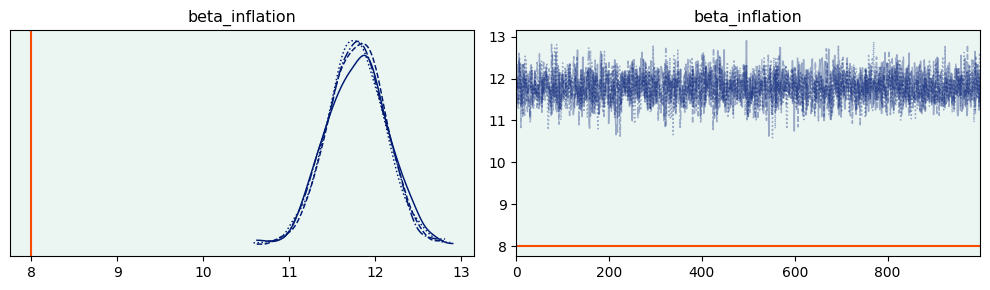

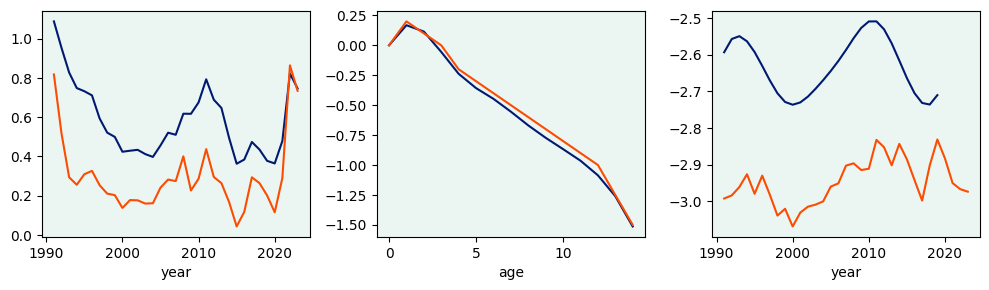

In [17]:
axs = az.plot_trace(apc_trace, var_names = ["beta_inflation"], figsize = (10, 3))
axs[0, 0].axvline(real_beta_inflation_period, color = palette[1])
axs[0, 1].axhline(real_beta_inflation_period, color = palette[1])
plt.tight_layout()

_, axs = plt.subplots(1, 3, figsize = (10, 3))
ax = axs[0]
period_pred = pd.Series(
    float(apc_trace["posterior"]["beta_inflation"].mean())*period_cohort_table["inflation"].values
)
period_cohort_table["period"].plot(ax = ax)
ax.plot(period_cohort_table.index, period_pred)

ax = axs[1]
pd.Series(
    np.dot(
        B_age,
        apc_trace["posterior"]["beta_age"].mean(axis = 1).mean(axis = 0)
    ), index = apc_df.index.get_level_values("age")
).drop_duplicates().plot(ax = ax)
real_beta_age.plot(ax = ax, color = palette[1])

ax = axs[2]
pd.Series(
    np.dot(
        B_cohort,
        apc_trace["posterior"]["beta_cohort"].mean(axis = 1).mean(axis = 0)
    ), index = apc_df.index.get_level_values("cohort")
).drop_duplicates().plot(ax = ax)
period_cohort_table["cohort"].plot(ax = ax, color = palette[1])

plt.tight_layout()